# Øvelse i beregning og visualisering af baseflow og median minimumsvandføring
I denne øvelse skal vi se på hvordan vi beregner baseflow (grundvandsbidraget) af afstrømningstidsserien. I forbindelse med beregningerne af baseflow anvender vi metoden der er dokumenteret af Gustard et al. (1992).

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

In [2]:
# Definer datafolderen og navnene på de enkelte afstrømningstidsserier:
## :
vandportal_dir = os.path.join('Vandloeb_medianminimum_og_baseflow', 'data')  # data folder

# Navne på kolonnefiler der er hentet ned fra Vandportalen
Vandfoeringsdata = ['45.23_Vandforing, Dognmiddel (DMP)_Dag.csv',
                   '430152_Vandforing, Dognmiddel (DMP)_Dag.csv',
                   '22.36_Vandforing, Dognmiddel (DMP)_Dag.csv']

In [25]:
## definer lokale funktioner:

# funktion til indlæsning af data hentet fra Vandportalen:
def read_data_vandportal(file_names, data_dir, encoding = 'ISO-8859-1', avg = None):
    df_dict = {}
    for ifile in file_names:
        tmp_file = os.path.join(vandportal_dir, ifile)
        df_dict[ifile] = pd.read_csv(tmp_file, skiprows=12, sep=';', encoding=encoding) #, index_col=0)
        df_dict[ifile]['Date'] = pd.to_datetime(df_dict[ifile]['Dato (DK normaltid)'], format='%d-%m-%Y %H:%M')
        df_dict[ifile] = df_dict[ifile].set_index('Date')
                
        if avg == 'day':
            df_dict[ifile] = df_dict[ifile].groupby(pd.Grouper(freq='d')).mean()
        
        col = df_dict[ifile]['Vandføring, Døgnmiddel (DMP) (l/s)']/1000.
        #print(col)
        
        df_dict[ifile]['Resultat'] = col.values
    
    return df_dict

# Funktion til beregning af Baseflow på baggrund af metoden beskrevet af:
"""
Low flow estimation in the United Kingdom
A. Gustard, A. Bullock and J. M. Dixon
December 1992
"""
def CalcBFI(df, col='Resultat'):
    # udfyld eventuelle manglende data med lineær interpolation:
    df = df.resample('D').ffill().interpolate()
    n = 5
    df_roling = df[col].rolling(n).min()[n - 1::n]

    QB = []
    QBdate = []
    for n in range(0, len(df_roling.index) - 3):
        df_tmp = df_roling[n:n + 3]
        if any(df_tmp.values[1] * 0.9 < df_tmp.values[0:3:2]):
            QB.append(df_tmp.values[1])
            QBdate.append(df_tmp.index[1])
        if not QB:
            QB = [0.0, 0.0]
            QBdate = [df_roling.index[0], df_roling.index[-1]]

    df_BFL = pd.DataFrame({'QB': QB}, index=QBdate)

    df_interpol = df_BFL.resample('D').mean()
    df_interpol['QB'] = df_interpol['QB'].interpolate()

    start = df_interpol.index[0]
    end = df_interpol.index[-1]

    bool_list = df_interpol.values[:, 0] > df[start:end][col].values
    Qdiff = df[start:end][col].values - df_interpol.values[:, 0]

    tmp_val = np.copy(df_interpol.values[:, 0])

    tmp_val[bool_list] = tmp_val[bool_list] + Qdiff[bool_list]

    df_interpol['QB'] = tmp_val

    BFI = np.sum(df_interpol.loc[start:end].values) / np.sum(df.loc[start:end][col].values)

    return df_interpol, BFI

### Indlæs data hentet fra Vandportalen

Data kan hentes fra [Vandportalen](https://vandportalen.dk/plotsmaps?config=vandloeb&days=7). Til denne specifikke opgave er der hentet data ned fra 3 vandløb forskellige steder i landet.

Baseret på stationsnummeret. Find de 3 vandføringsstationer i vandportalen. Hvad tror i der er kendetegnet ved de forskellige vandløb? 

In [27]:
vandfoer_dict = read_data_vandportal(file_names = Vandfoeringsdata, data_dir=vandportal_dir)

**Plot data fra alle vandføringsstationer i datasættet**:

Bemærk at der er nogle manglende data i den sidste tidsserie. Disse manglende værdier vil blive udfyldt med lineær interpolation i forbindelse med beregningen af baseflow og median minimum

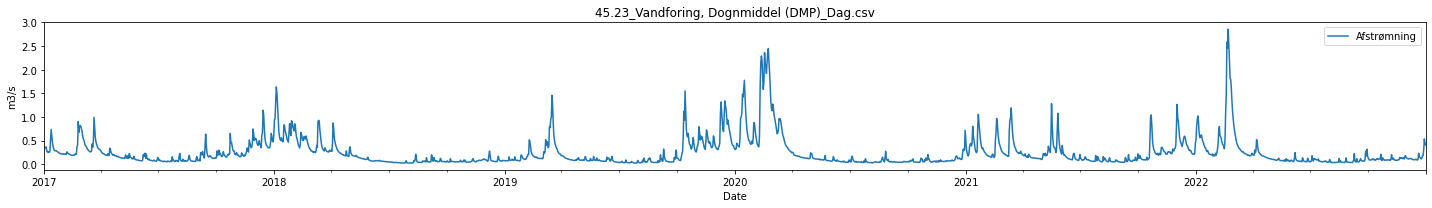

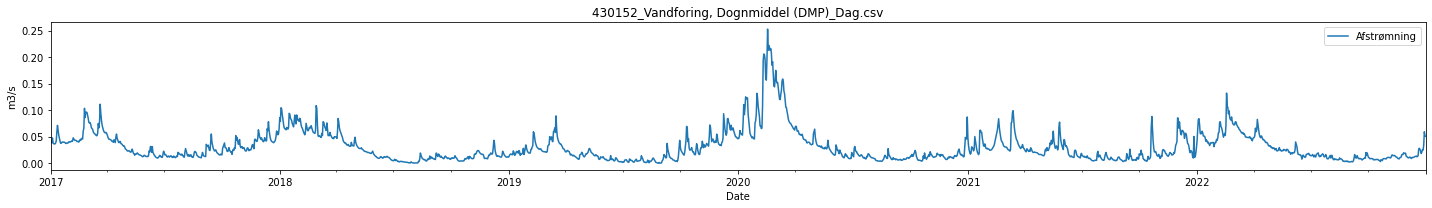

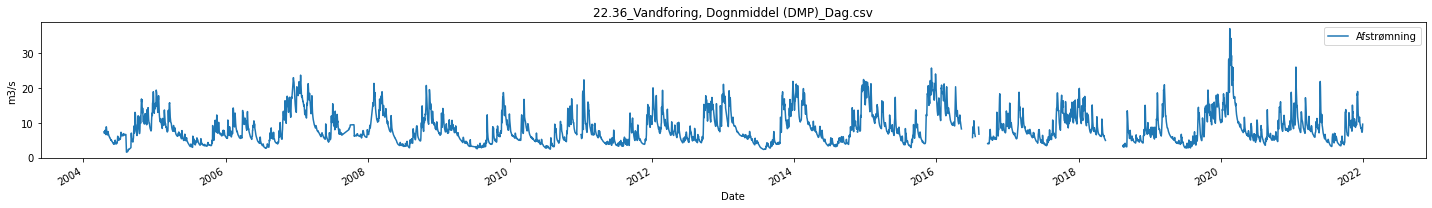

In [29]:
for ikey in vandfoer_dict.keys():
    fig = plt.figure(figsize = (20,3))
    ax = fig.add_subplot(111)
    
    vandfoer_dict[ikey]['Resultat'].plot(ax=ax, label = 'Afstrømning')
    
    ax.set_title(ikey)
    ax.set_ylabel('m3/s')
    plt.legend()
    plt.tight_layout()

In [11]:
for ikey in vandfoer_dict.keys():
    bf_df, BFI = CalcBFI(vandfoer_dict[ikey], col='Resultat')

# Beregn og plot Baseflow for de udvalgte vandløb:

- Hvad er kendetegnet ved baseflow i de enkelte vandløb. 

Median minimum for tidsserie: 45.23_Vandforing, Dognmiddel (DMP)_Dag.csv = 0.0315 m3/s
Median minimum for tidsserie: 430152_Vandforing, Dognmiddel (DMP)_Dag.csv = 0.0026 m3/s
Median minimum for tidsserie: 22.36_Vandforing, Dognmiddel (DMP)_Dag.csv = 2.9956 m3/s


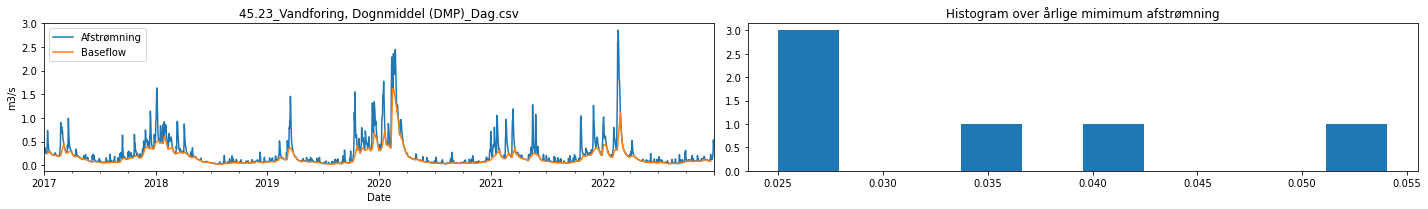

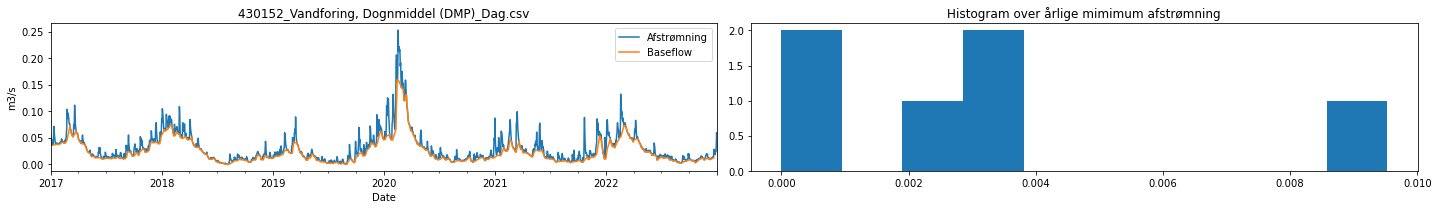

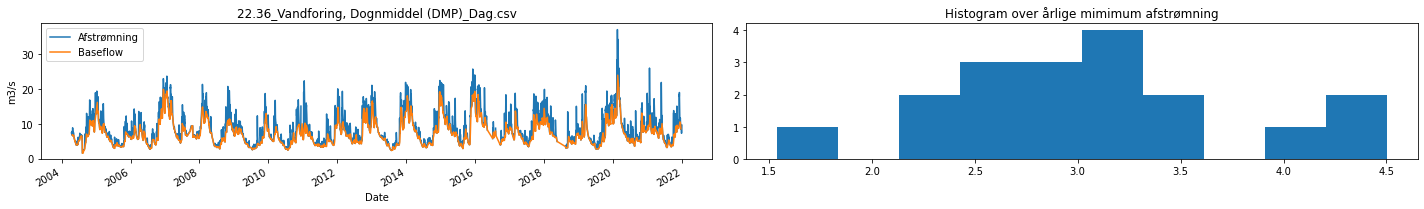

In [32]:
for ikey in vandfoer_dict.keys():
    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(20,3))
    
    vandfoer_dict[ikey]['Resultat'].plot(ax=ax1, label = 'Afstrømning')
    
    bf_df, BFI = CalcBFI(vandfoer_dict[ikey], col='Resultat')
    
    bf_df['QB'].plot(ax=ax1, label = 'Baseflow')
    
    ax1.set_title(ikey)
    ax1.set_ylabel('m3/s')
    ax1.legend()
    plt.tight_layout()
    
    ax2.hist(vandfoer_dict[ikey].groupby(vandfoer_dict[ikey].index.year).min()['Resultat'])
    median_min = vandfoer_dict[ikey].groupby(vandfoer_dict[ikey].index.year).min()['Resultat'].median()
    ax2.set_title('Histogram over årlige mimimum afstrømning')
    
    print('Median minimum for tidsserie: {} = {:.4f} m3/s'.format(ikey, median_min))